<a href="https://colab.research.google.com/github/bori00/BrainTumorClassification/blob/bori_dev/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Setup

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

import urllib
from urllib import request

import time

In [40]:
# Reproducability
SEED = 31415
def set_seed(seed=SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## Import Dataset

In [24]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# unzip the files containing the training and testing images
# important: this step assumes that you have the two zip files in 'BrainTumorClassification/Training.zip' and 'BrainTumorClassification/Testing.zip' in your Google Drive
!unzip gdrive/My\ Drive/BrainTumorClassification/Training.zip
!unzip gdrive/My\ Drive/BrainTumorClassification/Testing.zip

In [31]:
import pathlib
dataset_url = "https://drive.google.com/u/0/uc?id=1HK5JxUCzDAI812XOHEYZPFvVHuKGdxDg&export=download&confirm=t"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='tumor_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [32]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


## Create Dataframes

In [55]:
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32

In [60]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Training',
  shuffle=True,
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'Testing',
  shuffle=True,
  seed=SEED,
  image_size=IMAGE_SIZE, 
  batch_size=BATCH_SIZE)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


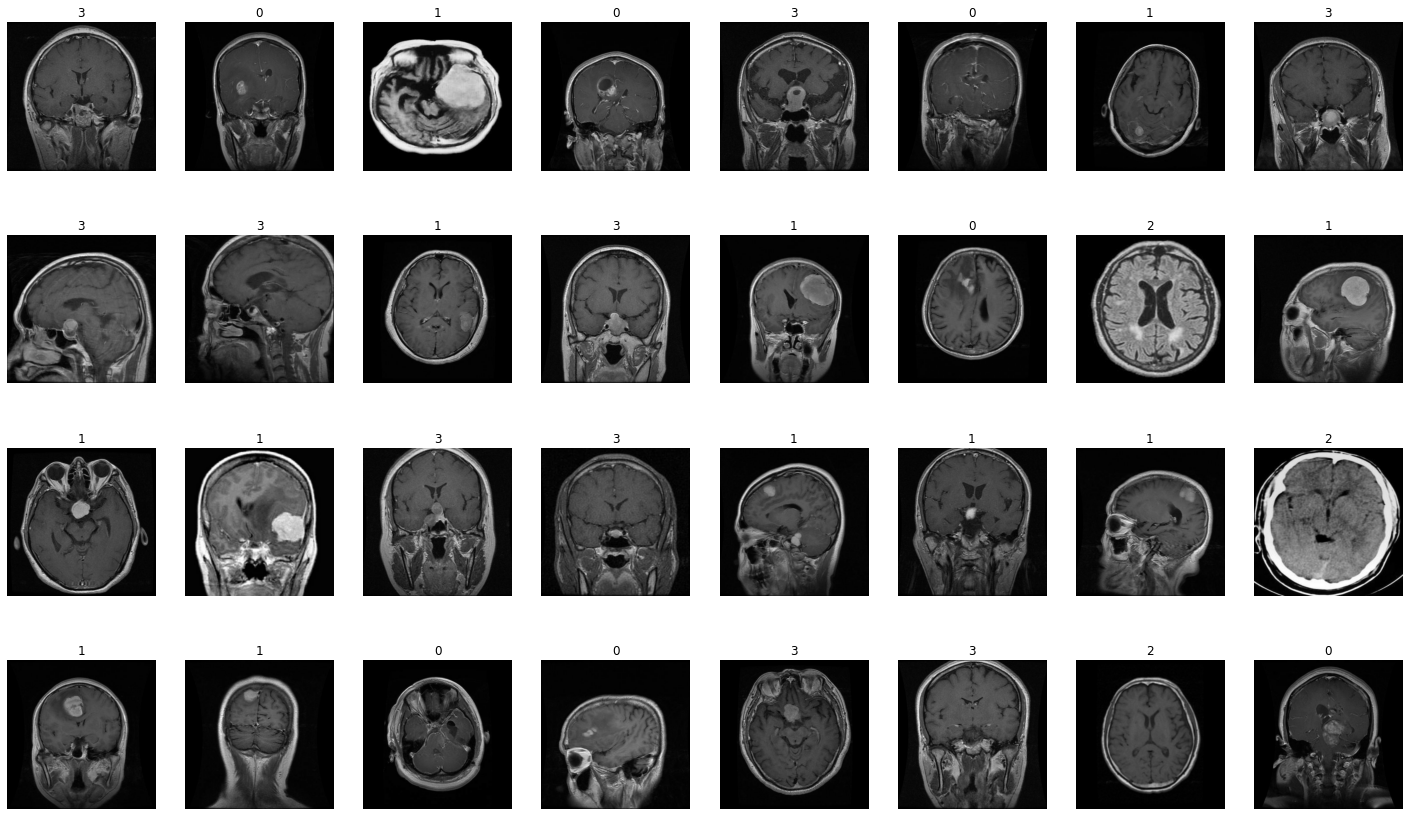

In [73]:
plt.figure(figsize=(25, 15))
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [71]:
for x, y in train_ds.take(1):
  print(x.shape, y)

(32, 512, 512, 3) tf.Tensor([0 1 2 3 1 2 2 0 1 1 1 0 3 2 1 0 2 1 0 1 3 1 1 1 1 3 0 0 3 2 3 3], shape=(32,), dtype=int32)


In [58]:
ex = next(iter(train_ds.unbatch().map(lambda x, y: x).batch(1)))
ex

<tf.Tensor: shape=(1, 512, 512, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dty